In [18]:
#### YOLOv10 (Fully Functional)

# STEP 0: Mount Google Drive (if dataset stored there)
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics opencv-python matplotlib numpy tqdm

from ultralytics import YOLO
import cv2
import glob
import torch
from tqdm import tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
%%writefile /content/Dataset1.yaml
path: /content/drive/My Drive/Colab Notebooks/Thesis_Dataset/Dataset1

train: train/images
val: valid/images
test: test/images

nc: 6
names:
  - propeller
  - pipe_type2
  - red_fin
  - net
  - qr_codes
  - pipe


Writing /content/Dataset1.yaml


In [4]:
device = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO("yolov10n.pt")  # official YOLOv10 model

model.train(
    data="/content/Dataset1.yaml",   # <-- your dataset YAML
    epochs=50,
    imgsz=640,
    batch=16,
    device=device
)


Using device: 0
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Dataset1.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f216e14b8c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [5]:
metrics = model.val(
    data="/content/Dataset1.yaml",
    split="test"
)

print("YOLOv10 mAP@0.5 (%):", metrics.box.map50 * 100)
print("YOLOv10 Precision (%):", metrics.box.mp * 100)
print("YOLOv10 Recall (%):", metrics.box.mr * 100)


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 17.4±37.8 ms, read: 0.2±0.1 MB/s, size: 169.1 KB)
val: Scanning /content/drive/My Drive/Colab Notebooks/Thesis_Dataset/Dataset1/test/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 318/318 66.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 2.7it/s 7.5s
                   all        318        435      0.955      0.955      0.986      0.845
             propeller         50         50      0.927       0.96      0.988      0.838
            pipe_type2         43         43      0.912      0.963      0.977      0.775
               red_fin         37         37      0.974      0.996      0.993      0.882
                   net         43         61      0.983      0.944      0.993      0.943
   

In [6]:
def draw_yolo_gt(img, label_path):
    H, W, _ = img.shape
    with open(label_path) as f:
        for line in f:
            c, x, y, w, h = map(float, line.split())
            x1 = int((x - w/2) * W)
            y1 = int((y - h/2) * H)
            x2 = int((x + w/2) * W)
            y2 = int((y + h/2) * H)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)



0: 384x640 1 pipe_type2, 1 pipe, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


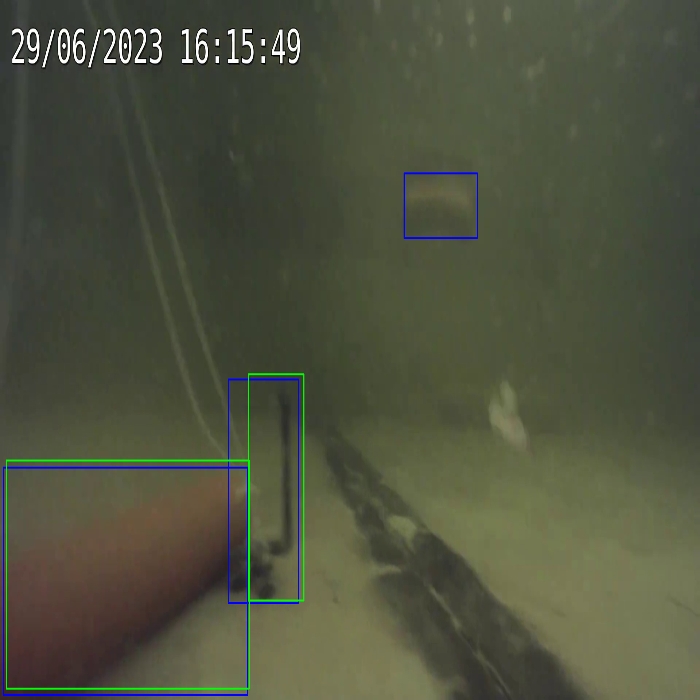


0: 384x640 1 qr_codes, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


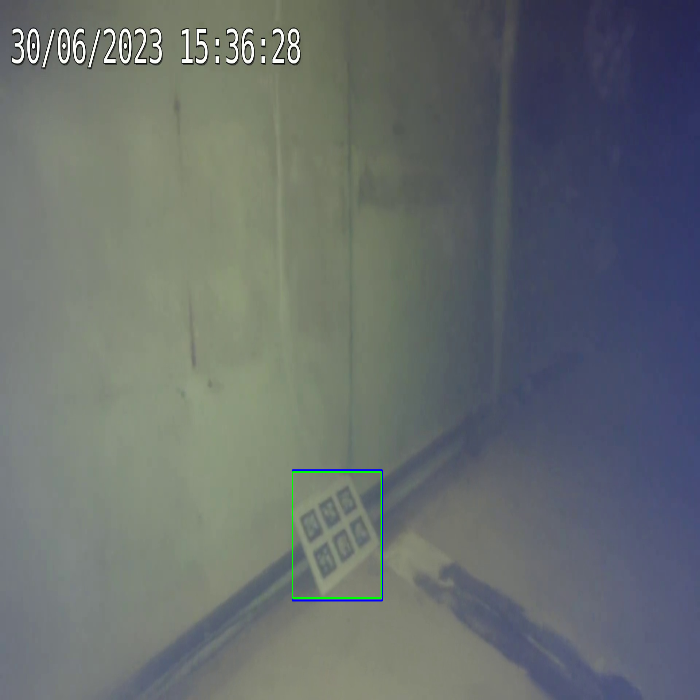


0: 384x640 1 qr_codes, 11.1ms
Speed: 3.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


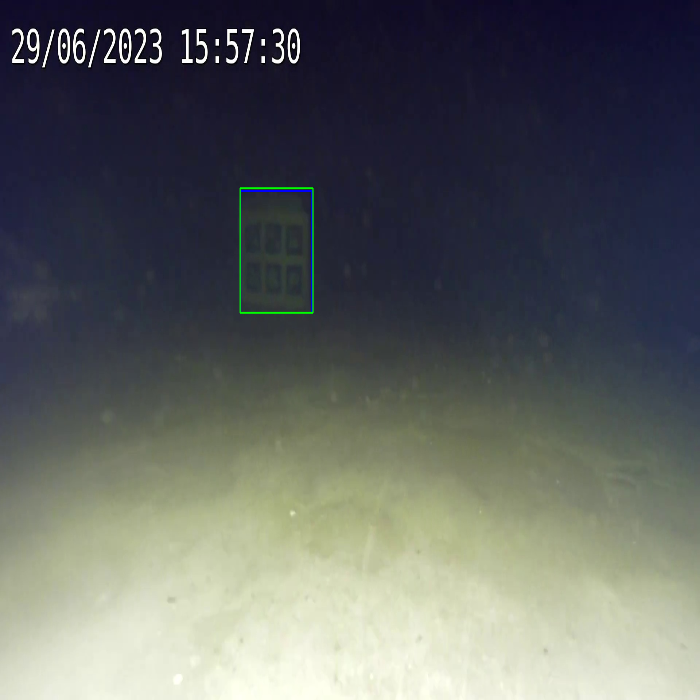


0: 384x640 1 qr_codes, 24.6ms
Speed: 14.9ms preprocess, 24.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


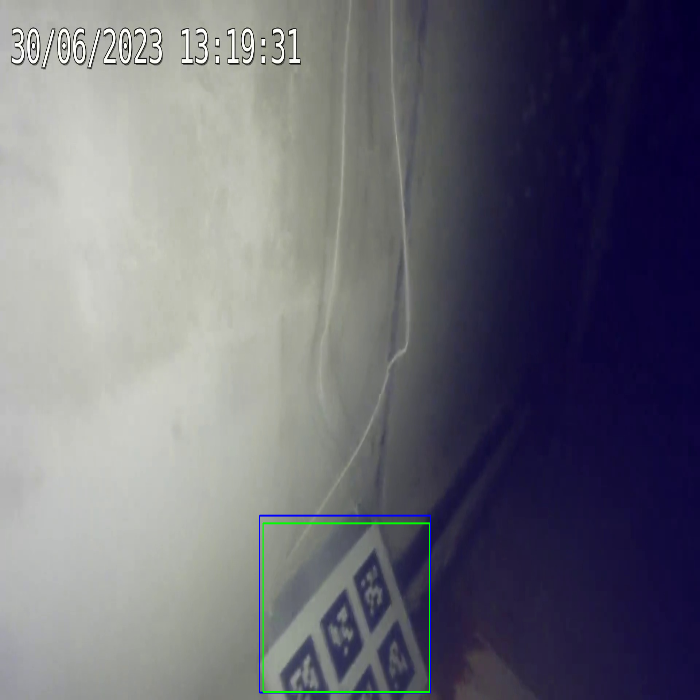


0: 384x640 1 pipe, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


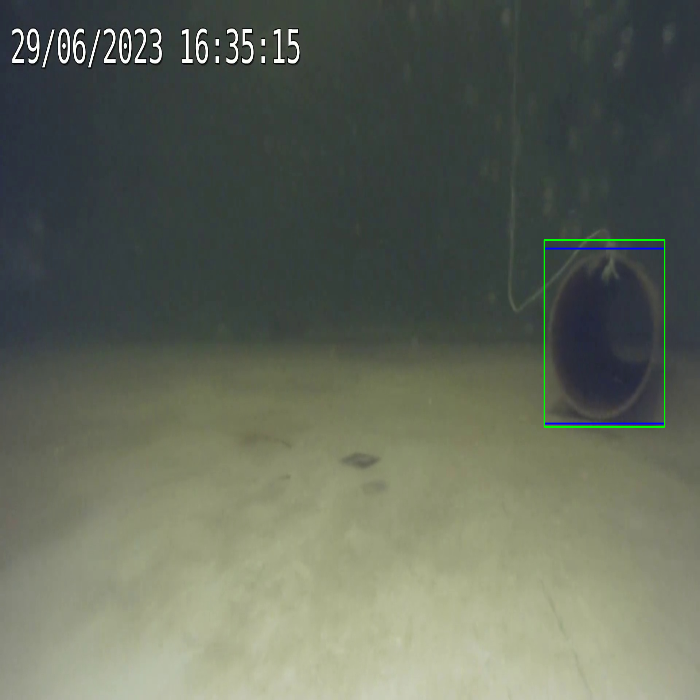


0: 384x640 (no detections), 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


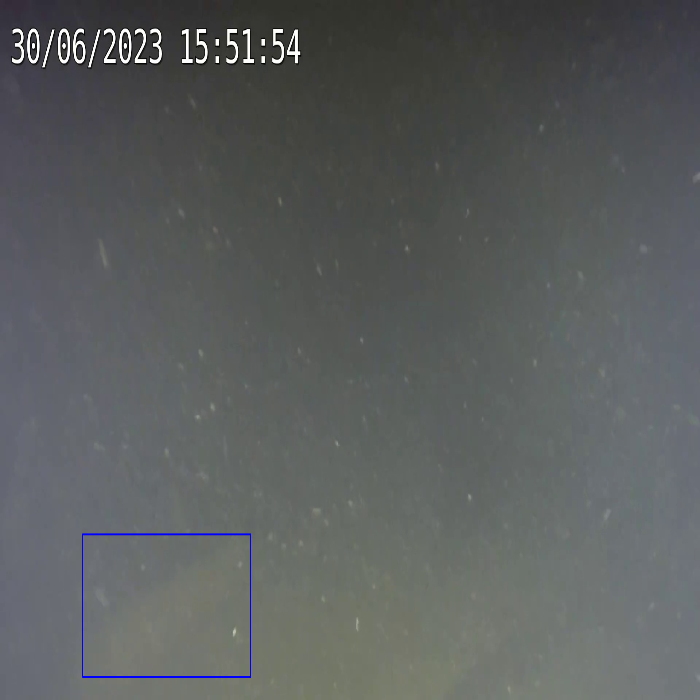


0: 384x640 1 pipe_type2, 11.4ms
Speed: 3.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


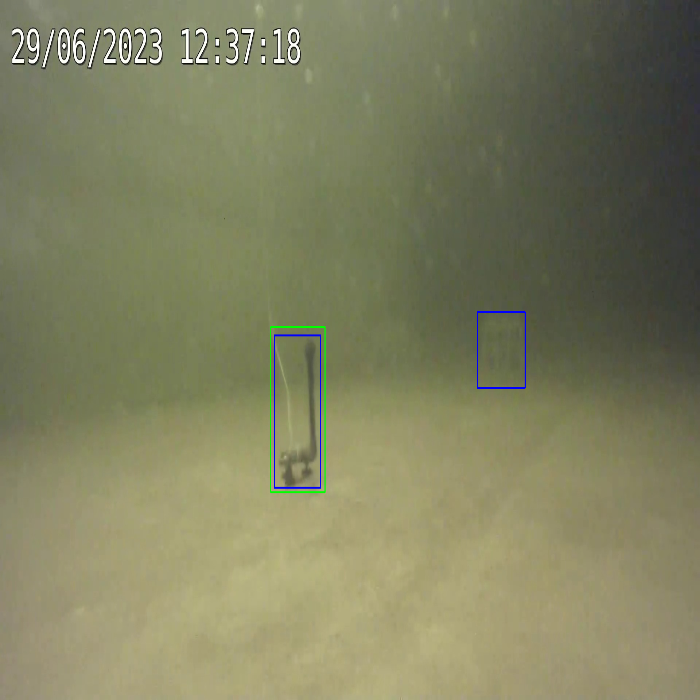


0: 384x640 1 qr_codes, 10.9ms
Speed: 3.2ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


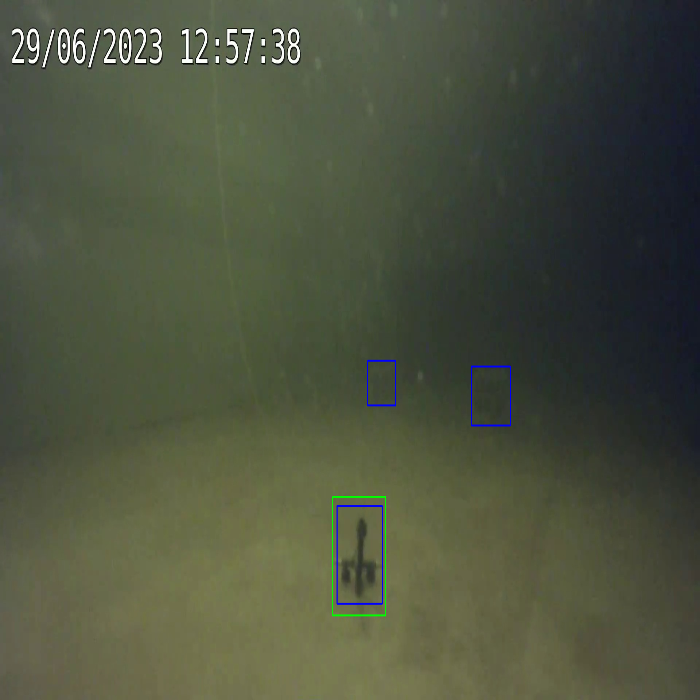


0: 384x640 2 pipes, 10.6ms
Speed: 3.5ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


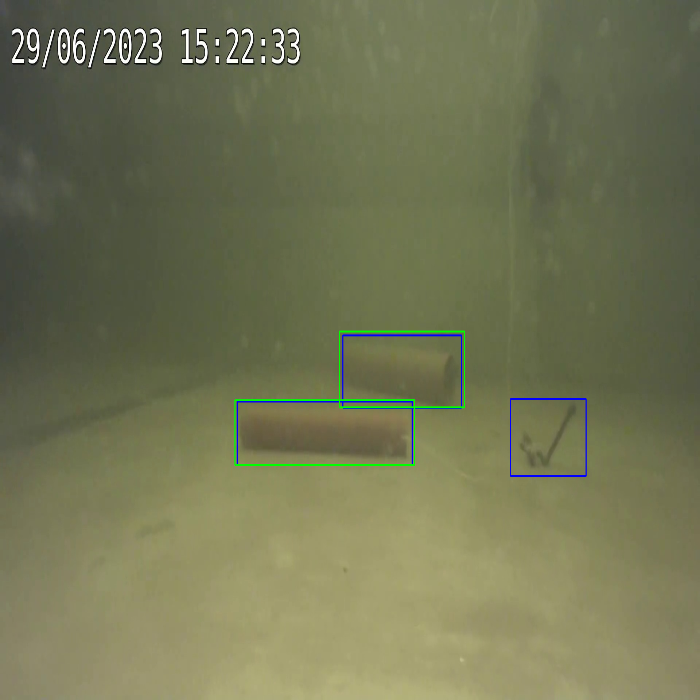


0: 384x640 1 qr_codes, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


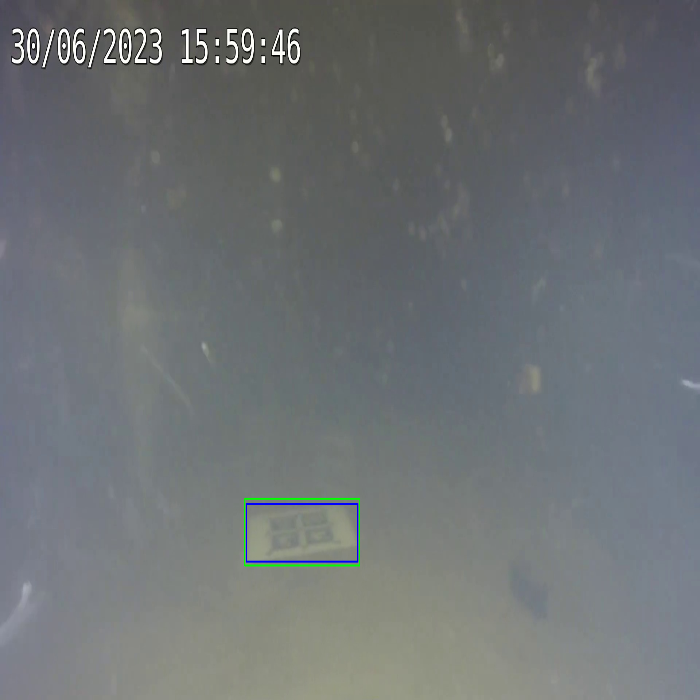

In [13]:
import cv2
import glob
from google.colab.patches import cv2_imshow

def read_yolo_labels(txt_file):
    labels=[]
    with open(txt_file) as f:
        for line in f:
            c,x,y,w,h = line.split()
            labels.append([int(c),float(x),float(y),float(w),float(h)])
    return labels

test_images = glob.glob(
    "/content/drive/My Drive/Colab Notebooks/Thesis_Dataset/Dataset1/test/images/*.jpg"
)

for img_path in test_images[:10]:
    img = cv2.imread(img_path)
    H,W,_ = img.shape

    # Draw ground truth (BLUE)
    label_path = img_path.replace("images","labels").replace(".jpg",".txt")
    gts = read_yolo_labels(label_path)

    for c,x,y,w,h in gts:
        x1=int((x-w/2)*W); y1=int((y-h/2)*H)
        x2=int((x+w/2)*W); y2=int((y+h/2)*H)
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)

    # Predictions (GREEN)
    results = model(img)[0]
    for box in results.boxes.xyxy.cpu().numpy().astype(int):
        x1,y1,x2,y2 = box
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)

    cv2_imshow(cv2.resize(img,(700,700)))


In [16]:
def IoU(a, b):
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (a[2] - a[0]) * (a[3] - a[1])
    areaB = (b[2] - b[0]) * (b[3] - b[1])
    return inter / (areaA + areaB - inter + 1e-6)
correct, total = 0, 0

for img_path in tqdm(test_images):
    img = cv2.imread(img_path)
    H, W, _ = img.shape

    gt_boxes = []
    with open(img_path.replace("images", "labels").replace(".jpg", ".txt")) as f:
        for line in f:
            c, x, y, w, h = map(float, line.split())
            gt_boxes.append([
                int((x - w/2) * W),
                int((y - h/2) * H),
                int((x + w/2) * W),
                int((y + h/2) * H),
                int(c)
            ])

    preds = model(img)[0]
    for box, cls in zip(preds.boxes.xyxy, preds.boxes.cls):
        total += 1
        p = [*box.int().tolist(), int(cls)]
        for g in gt_boxes:
            if p[4] == g[4] and IoU(p[:4], g[:4]) >= 0.5:
                correct += 1
                break



  0%|          | 0/318 [00:00<?, ?it/s]


0: 384x640 1 pipe_type2, 1 pipe, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 3/318 [00:00<00:10, 28.98it/s]


0: 384x640 2 qr_codess, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 6/318 [00:00<00:10, 29.07it/s]


0: 384x640 1 pipe_type2, 1 qr_codes, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 qr_codes, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 2 pipes, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 13.6ms
Speed: 2.6ms preprocess, 13.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 10/318 [00:00<00:10, 29.41it/s]


0: 384x640 1 pipe, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 13/318 [00:00<00:10, 28.59it/s]


0: 384x640 2 nets, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 2 pipes, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 17/318 [00:00<00:10, 29.70it/s]


0: 384x640 1 pipe, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 21/318 [00:00<00:09, 30.23it/s]


0: 384x640 1 propeller, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 1 qr_codes, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 25/318 [00:00<00:09, 30.77it/s]


0: 384x640 1 red_fin, 1 pipe, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe_type2, 1 pipe, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 17.1ms
Speed: 4.2ms preprocess, 17.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 29/318 [00:00<00:09, 29.47it/s]


0: 384x640 1 net, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pipes, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 32/318 [00:01<00:09, 28.95it/s]


0: 384x640 1 pipe, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 36/318 [00:01<00:09, 30.08it/s]


0: 384x640 3 pipes, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 40/318 [00:01<00:09, 30.08it/s]


0: 384x640 1 red_fin, 1 pipe, 10.5ms
Speed: 2.7ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 44/318 [00:01<00:09, 29.45it/s]


0: 384x640 1 net, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 pipe, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 48/318 [00:01<00:09, 30.00it/s]


0: 384x640 1 qr_codes, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 52/318 [00:01<00:08, 30.46it/s]


0: 384x640 1 pipe_type2, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 56/318 [00:01<00:08, 30.68it/s]


0: 384x640 1 pipe, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 60/318 [00:02<00:08, 30.09it/s]


0: 384x640 2 nets, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 64/318 [00:02<00:08, 30.29it/s]


0: 384x640 1 pipe, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 68/318 [00:02<00:08, 30.58it/s]


0: 384x640 1 pipe, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 red_fin, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 72/318 [00:02<00:07, 30.76it/s]


0: 384x640 1 red_fin, 12.7ms
Speed: 6.3ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pipes, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 76/318 [00:02<00:08, 29.61it/s]


0: 384x640 1 pipe_type2, 2 qr_codess, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 80/318 [00:02<00:07, 30.04it/s]


0: 384x640 1 qr_codes, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 qr_codes, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pipes, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 84/318 [00:02<00:07, 29.40it/s]


0: 384x640 1 pipe_type2, 9.2ms
Speed: 3.7ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe_type2, 1 pipe, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 1 pipe, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 88/318 [00:02<00:07, 29.98it/s]


0: 384x640 1 pipe, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 92/318 [00:03<00:07, 29.98it/s]


0: 384x640 1 pipe, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipe_type2s, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 96/318 [00:03<00:07, 30.71it/s]


0: 384x640 2 nets, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 100/318 [00:03<00:07, 30.86it/s]


0: 384x640 2 qr_codess, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe_type2, 1 pipe, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 qr_codes, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 104/318 [00:03<00:07, 30.52it/s]


0: 384x640 1 propeller, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 108/318 [00:03<00:07, 29.89it/s]


0: 384x640 1 propeller, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.8ms
Speed: 1.9ms preprocess, 8.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 111/318 [00:03<00:07, 29.33it/s]


0: 384x640 2 pipes, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 115/318 [00:03<00:06, 30.02it/s]


0: 384x640 1 qr_codes, 1 pipe, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 pipes, 12.5ms
Speed: 2.5ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 118/318 [00:03<00:07, 28.37it/s]


0: 384x640 2 qr_codess, 14.5ms
Speed: 4.2ms preprocess, 14.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 red_fin, 1 pipe, 12.1ms
Speed: 3.9ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 14.1ms
Speed: 5.9ms preprocess, 14.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 121/318 [00:04<00:07, 25.58it/s]


0: 384x640 1 propeller, 1 pipe, 11.3ms
Speed: 4.6ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 14.2ms
Speed: 2.8ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 124/318 [00:04<00:07, 24.31it/s]


0: 384x640 3 pipes, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 127/318 [00:04<00:07, 24.03it/s]


0: 384x640 1 pipe, 9.6ms
Speed: 3.4ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 130/318 [00:04<00:07, 24.58it/s]


0: 384x640 2 nets, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 133/318 [00:04<00:07, 24.75it/s]


0: 384x640 1 red_fin, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 qr_codess, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 12.4ms
Speed: 4.2ms preprocess, 12.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 136/318 [00:04<00:07, 25.00it/s]


0: 384x640 1 pipe, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 nets, 10.3ms
Speed: 4.0ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 139/318 [00:04<00:07, 23.70it/s]


0: 384x640 1 qr_codes, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 1 pipe, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 142/318 [00:04<00:07, 24.91it/s]


0: 384x640 1 pipe, 16.4ms
Speed: 2.6ms preprocess, 16.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 145/318 [00:05<00:06, 25.24it/s]


0: 384x640 1 qr_codes, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.8ms
Speed: 4.2ms preprocess, 9.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 2 pipe_type2s, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 148/318 [00:05<00:06, 26.27it/s]


0: 384x640 1 pipe, 11.6ms
Speed: 4.6ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 15.8ms
Speed: 3.0ms preprocess, 15.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 13.0ms
Speed: 3.8ms preprocess, 13.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 151/318 [00:05<00:06, 24.90it/s]


0: 384x640 1 pipe, 12.3ms
Speed: 2.7ms preprocess, 12.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe_type2, 1 pipe, 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 154/318 [00:05<00:06, 23.89it/s]


0: 384x640 1 pipe, 14.5ms
Speed: 6.0ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 14.6ms
Speed: 4.1ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 157/318 [00:05<00:07, 22.40it/s]


0: 384x640 1 propeller, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.3ms
Speed: 3.7ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 160/318 [00:05<00:06, 22.76it/s]


0: 384x640 1 pipe, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipes, 10.0ms
Speed: 2.6ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 1 pipe, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 163/318 [00:05<00:06, 23.22it/s]


0: 384x640 1 propeller, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 166/318 [00:05<00:06, 23.61it/s]


0: 384x640 2 qr_codess, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 169/318 [00:06<00:05, 24.90it/s]


0: 384x640 1 pipe_type2, 1 qr_codes, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 172/318 [00:06<00:05, 25.83it/s]


0: 384x640 3 nets, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 175/318 [00:06<00:05, 26.45it/s]


0: 384x640 1 pipe_type2, 1 red_fin, 11.7ms
Speed: 4.5ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 178/318 [00:06<00:05, 26.11it/s]


0: 384x640 1 pipe_type2, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 nets, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 181/318 [00:06<00:05, 26.77it/s]


0: 384x640 1 propeller, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 184/318 [00:06<00:04, 27.26it/s]


0: 384x640 1 pipe, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 pipe, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 187/318 [00:06<00:04, 26.59it/s]


0: 384x640 1 qr_codes, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 1 pipe, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 190/318 [00:06<00:05, 25.46it/s]


0: 384x640 1 pipe, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe, 14.6ms
Speed: 3.6ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 193/318 [00:07<00:05, 24.99it/s]


0: 384x640 1 pipe_type2, 1 pipe, 15.0ms
Speed: 3.1ms preprocess, 15.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.9ms
Speed: 5.1ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 196/318 [00:07<00:04, 24.66it/s]


0: 384x640 1 pipe, 15.0ms
Speed: 3.3ms preprocess, 15.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 10.8ms
Speed: 4.6ms preprocess, 10.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 14.4ms
Speed: 3.6ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 199/318 [00:07<00:05, 23.76it/s]


0: 384x640 1 pipe, 14.7ms
Speed: 4.7ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 14.6ms
Speed: 3.9ms preprocess, 14.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 propellers, 12.3ms
Speed: 4.0ms preprocess, 12.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 202/318 [00:07<00:05, 22.86it/s]


0: 384x640 2 qr_codess, 13.9ms
Speed: 4.0ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 18.2ms
Speed: 4.7ms preprocess, 18.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 2 qr_codess, 16.4ms
Speed: 3.8ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 205/318 [00:07<00:05, 21.42it/s]


0: 384x640 1 qr_codes, 16.2ms
Speed: 2.7ms preprocess, 16.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 13.9ms
Speed: 4.7ms preprocess, 13.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 propellers, 1 pipe_type2, 1 pipe, 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 208/318 [00:07<00:05, 20.99it/s]


0: 384x640 1 qr_codes, 12.6ms
Speed: 4.0ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 211/318 [00:07<00:04, 22.41it/s]


0: 384x640 2 qr_codess, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 215/318 [00:07<00:04, 24.64it/s]


0: 384x640 2 qr_codess, 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 propellers, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 218/318 [00:08<00:04, 24.90it/s]


0: 384x640 1 net, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 221/318 [00:08<00:03, 25.97it/s]


0: 384x640 1 red_fin, 9.1ms
Speed: 4.6ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 qr_codess, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 224/318 [00:08<00:03, 25.80it/s]


0: 384x640 1 qr_codes, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.9ms
Speed: 3.8ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 228/318 [00:08<00:03, 27.00it/s]


0: 384x640 1 net, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 231/318 [00:08<00:03, 27.35it/s]


0: 384x640 1 red_fin, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 qr_codes, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 235/318 [00:08<00:02, 28.39it/s]


0: 384x640 3 qr_codess, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 pipe_type2s, 7.4ms
Speed: 3.9ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 239/318 [00:08<00:02, 28.04it/s]


0: 384x640 1 propeller, 1 pipe_type2, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 242/318 [00:08<00:02, 28.30it/s]


0: 384x640 1 net, 2 qr_codess, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 245/318 [00:09<00:02, 28.64it/s]


0: 384x640 1 pipe_type2, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 249/318 [00:09<00:02, 29.05it/s]


0: 384x640 2 qr_codess, 7.4ms
Speed: 4.4ms preprocess, 7.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 1 qr_codes, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 252/318 [00:09<00:02, 29.12it/s]


0: 384x640 3 nets, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 255/318 [00:09<00:02, 28.97it/s]


0: 384x640 1 propeller, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 259/318 [00:09<00:02, 29.40it/s]


0: 384x640 1 propeller, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 262/318 [00:09<00:01, 29.45it/s]


0: 384x640 (no detections), 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 1 pipe, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 266/318 [00:09<00:01, 29.81it/s]


0: 384x640 1 propeller, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 269/318 [00:09<00:01, 27.99it/s]


0: 384x640 1 red_fin, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 7.5ms
Speed: 4.3ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 2 qr_codess, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 9.1ms
Speed: 4.8ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 273/318 [00:09<00:01, 28.71it/s]


0: 384x640 1 qr_codes, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 276/318 [00:10<00:01, 28.87it/s]


0: 384x640 1 pipe_type2, 1 qr_codes, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 279/318 [00:10<00:01, 28.80it/s]


0: 384x640 2 qr_codess, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 2 qr_codess, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 282/318 [00:10<00:01, 28.69it/s]


0: 384x640 2 qr_codess, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 286/318 [00:10<00:01, 29.60it/s]


0: 384x640 1 qr_codes, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nets, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 289/318 [00:10<00:00, 29.58it/s]


0: 384x640 1 qr_codes, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 292/318 [00:10<00:00, 28.91it/s]


0: 384x640 1 net, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 1 pipe, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 10.9ms
Speed: 4.8ms preprocess, 10.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 295/318 [00:10<00:00, 28.71it/s]


0: 384x640 1 propeller, 1 pipe_type2, 7.9ms
Speed: 4.4ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 298/318 [00:10<00:00, 28.90it/s]


0: 384x640 1 qr_codes, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 1 red_fin, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 301/318 [00:10<00:00, 28.69it/s]


0: 384x640 1 pipe_type2, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 304/318 [00:11<00:00, 28.72it/s]


0: 384x640 1 pipe_type2, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 qr_codes, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 308/318 [00:11<00:00, 29.48it/s]


0: 384x640 2 nets, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 311/318 [00:11<00:00, 29.60it/s]


0: 384x640 1 red_fin, 7.4ms
Speed: 3.8ms preprocess, 7.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 net, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 pipe_type2, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 314/318 [00:11<00:00, 29.48it/s]


0: 384x640 1 propeller, 7.6ms
Speed: 3.9ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 qr_codess, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 propeller, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 red_fin, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 318/318 [00:11<00:00, 27.56it/s]


In [17]:
print("YOLOv10 Detection Accuracy (%):", (correct / total) * 100)

YOLOv10 Detection Accuracy (%): 96.27192982456141
